Let’s import the libraries that we are going to use for data manipulation, visualization, training the model, etc.

In [1]:
# import library to ploting
# import matplotlib.ticker as tkr
import matplotlib.pyplot as plt
# import urllib.request
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
%matplotlib inline
import numpy as np
# avoid alert
import warnings
warnings.filterwarnings('ignore')
# import library to preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from pandas.io.json import json_normalize
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# import datetime as dt
from scipy import stats
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.stattools import pacf
# import requests
# import locale
# import json, tempfile
# import math
# performace metrics libray
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# select the GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # SET A SINGLE GPU
from util import *
# import library modules keras and tensorflow
# from keras.layers import *
import tensorflow as tf
from keras.layers import Dense, LSTM, GRU, Dropout
import tensorflow_docs as tfdocs
# import tensorflow_docs.plots
# import tensorflow_docs.modeling
# import matplotlib.image  as mpimg
from keras.models import Sequential, Model, Input
from keras import regularizers
from keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


### Load the datasets

In [2]:
def load_dataset(file2015, file2016, file2017, file2018):
    base_2015 = pd.read_json(file2015)
    print('Dataset 2015 => ', base_2015.shape)
    base_2016 = pd.read_json(file2016)
    print('Dataset 2016 => ', base_2016.shape)
    base_2017 = pd.read_json(file2017)
    print('Dataset 2017 => ', base_2017.shape)
    base_2018 = pd.read_json(file2018)
    print('Dataset 2018 => ', base_2018.shape)
    return base_2015, base_2016, base_2017, base_2018

In [3]:
base_2015, base_2016, base_2017, base_2018 = load_dataset('../arquivos/base_bruta/br2015-2.json', 
             '../arquivos/base_bruta/br2016.json', 
             '../arquivos/base_bruta/br2017full.json',
            '../arquivos/base_bruta/br2018.json')

Dataset 2015 =>  (1829189, 19)
Dataset 2016 =>  (2498313, 19)
Dataset 2017 =>  (2629808, 24)
Dataset 2018 =>  (5288424, 24)


In [2]:
def drop_col_values_missing(dataset):
    dataset = dataset.drop(['AS_name','_id','city','elapsed_target','internal_address','platform','real_address','remote_address','version',],axis=1)
    dataset.dropna(inplace=True)
    print('\nSum values end missing:\n')
    print(dataset.isna().sum())
    print('\n', dataset.shape)
    return dataset

In [3]:
def drop_col_values_missing_another(dataset):
    dataset = dataset.drop(['AS_name','_id','city',
                                  'elapsed_target','internal_address',
                                  'platform','real_address',
                                  'remote_address','version',
                                  'engine_name','engine_version',
                                  'fast_scale_down','constant_bitrate',
                                  'use_fixed_rates'], axis=1)
    dataset.dropna(inplace=True)
    print('\nSum the end missing values:\n')
    print(dataset.isna().sum())
    print('\nLast shape:\n', dataset.shape)
    return dataset

In [5]:
def cria_sessao(df):
    # performace: O(n**2)
    print("creating session...")
    df.sort_values(['uuid','timestamp','iteration'], inplace=True)
    df['session'] = df['iteration']

    val = df.uuid.value_counts()
    val = val.index

    cont = -1
    aux = df[df['uuid'] == val[0]]
    x2 = aux.index
    x2 = x2[0]    
    for i in val:
        aux = df[df['uuid'] == i]
        for x in aux.index:
            if df.iteration.loc[x] <= df.iteration.loc[x2]:
                cont += 1
            df.session.loc[x] = cont
            x2 = x
    return df

In [4]:
def drop_not_year(base, year):
    # base.sort_values(['timestamp','uuid','iteration'], inplace=True, ascending=True)
    indice = base[base['timestamp'].dt.year != year].index
    base.drop(indice, inplace=True)
    base = base.reset_index(drop=True)
    print('\n', base.shape)
    return base

In [5]:
def sort_df(df, column_idx):
    '''Takes dataframe, column index and custom function for sorting, 
    returns dataframe sorted by this column using this function'''
    
    col = df.ix[:,column_idx]
    temp = pd.DataFrame([])
    temp[0] = col
    temp[1] = df.index
    temp = temp.values.tolist()
    df = df.ix[[i[1] for i in sorted(temp, key=None)]]
    return df

### Data from year 2015

In [7]:
dataset_2015 = base_2015.copy()
print('\nSum values missing:\n')
print(dataset_2015.isnull().sum())
dataset_2015 = drop_col_values_missing(dataset_2015)
dataset_2015 = drop_not_year(dataset_2015, 2015)
# dataset_2015['timestamp'] = dataset_2015['timestamp'] - datetime.timedelta(hours=4)


Sum values missing:

AS_name                30
_id                     0
city                53425
connect_time            0
delta_sys_time          0
delta_user_time         0
elapsed                 0
elapsed_target          0
internal_address        0
iteration               0
platform                0
rate                    0
real_address            0
received                0
remote_address          0
request_ticks           0
timestamp               0
uuid                    0
version                 0
dtype: int64

Sum values end missing:

connect_time       0
delta_sys_time     0
delta_user_time    0
elapsed            0
iteration          0
rate               0
received           0
request_ticks      0
timestamp          0
uuid               0
dtype: int64

 (1829189, 10)

 (1829009, 10)


In [33]:
dataset_2015 = dataset_2015.groupby([dataset_2015.uuid, dataset_2015.iteration, dataset_2015.timestamp])

In [ ]:
# dataset_2015 = cria_sessao(dataset_2015)
# dataset_2015.to_csv('../base_vazao_sessao_2015.csv', encoding='utf-8', index=False)

### Estatísticas

In [ ]:
dataset_2015.info()

In [ ]:
dataset_2015.describe()

###  Data from year 2016

In [32]:
####### data from year 2016 #########
dataset_2016 = base_2016.copy()
print('Sum values missing initial:\n')
print(dataset_2016.isna().sum())
dataset_2016 = drop_col_values_missing(dataset_2016)
dataset_2016 = drop_not_year(dataset_2016, 2016)
# dataset_2016 = cria_sessao(dataset_2016)
# dataset_2016.to_csv('../base_vazao_sessao_2016.csv', encoding='utf-8', index=False)

Sum values missing initial:

AS_name                 0
_id                     0
city                68325
connect_time            0
delta_sys_time          0
delta_user_time         0
elapsed                 0
elapsed_target          0
internal_address        0
iteration               0
platform                0
rate                    0
real_address            0
received                0
remote_address          0
request_ticks           0
timestamp               0
uuid                    0
version                 0
dtype: int64

Sum values end missing:

connect_time       0
delta_sys_time     0
delta_user_time    0
elapsed            0
iteration          0
rate               0
received           0
request_ticks      0
timestamp          0
uuid               0
dtype: int64

 (2498313, 10)

 (2498179, 10)


### Estatísticas

In [ ]:
dataset_2016.info()

In [ ]:
dataset_2016.describe()

### Data from year 2017

In [37]:
dataset_2017 = base_2017.copy()
print('Sum initial missing values:\n')
print(dataset_2017.isna().sum())
dataset_2017 = drop_col_values_missing_another(dataset_2017)
dataset_2017 = drop_not_year(dataset_2017, 2017)
# dataset_2017 = cria_sessao(dataset_2017)
# dataset_2017.to_csv('../base_vazao_sessao_2017.csv', encoding='utf-8', index=False)

Sum initial missing values:

AS_name                 285
_id                       0
city                  64313
connect_time              0
constant_bitrate    2620644
delta_sys_time            0
delta_user_time           0
elapsed                   0
elapsed_target            0
engine_name         2620644
engine_version      2620644
fast_scale_down     2620644
internal_address          0
iteration                 0
platform                  0
rate                      0
real_address              0
received                  0
remote_address            0
request_ticks             0
timestamp                 0
use_fixed_rates     2620644
uuid                      0
version                   0
dtype: int64

Sum the end missing values:

connect_time       0
delta_sys_time     0
delta_user_time    0
elapsed            0
iteration          0
rate               0
received           0
request_ticks      0
timestamp          0
uuid               0
dtype: int64

Last shape:
 (2629808, 10)

 (26

### Estatísticas

In [ ]:
dataset_2017.info()

In [ ]:
dataset_2017.describe()

### Data from year 2018

In [88]:
dataset_2018 = base_2018.copy()
print('Sum values missing initial:\n')
print(dataset_2018.isnull().sum())
dataset_2018 = drop_col_values_missing_another(dataset_2018)
dataset_2018 = drop_not_year(dataset_2018, 2018)
# dataset_2018 = cria_sessao(dataset_2018)
# dataset_2018.to_csv('../base_vazao_sessao_2018.csv', encoding='utf-8', index=False)

Sum values missing initial:

AS_name               35184
_id                       0
city                  57983
connect_time              0
constant_bitrate    5248452
delta_sys_time            0
delta_user_time           0
elapsed                   0
elapsed_target            0
engine_name         5248452
engine_version      5248452
fast_scale_down     5248452
internal_address          0
iteration                 0
platform                  0
rate                      0
real_address              0
received                  0
remote_address            0
request_ticks             0
timestamp                 0
use_fixed_rates     5248452
uuid                      0
version                   0
dtype: int64

Sum the end missing values:

connect_time       0
delta_sys_time     0
delta_user_time    0
elapsed            0
iteration          0
rate               0
received           0
request_ticks      0
timestamp          0
uuid               0
dtype: int64

Last shape:
 (5288424, 10)

 (52

In [89]:
# dataset_2018.to_csv('../base_vazao_2018_2.csv', encoding='utf-8', index=False)

### Estatísticas

In [ ]:
dataset_2018.info()

In [ ]:
dataset_2018.describe()

### 1. Merge DataSets

In [2]:
dataset_sess_2015 = pd.read_csv('../arquivos/sessao_neubot/base_vazao_sessao_2015.csv')
print(dataset_sess_2015.shape)
dataset_sess_2016 = pd.read_csv('../arquivos/sessao_neubot/base_vazao_sessao_2016.csv')
print(dataset_sess_2016.shape)
dataset_sess_2017 = pd.read_csv('../arquivos/sessao_neubot/base_vazao_sessao_2017.csv')
print(dataset_sess_2017.shape)
dataset_sess_2018 = pd.read_csv('../arquivos/sessao_neubot/base_vazao_sessao_2018.csv')
print(dataset_sess_2018.shape)

(1829009, 11)
(2498179, 11)
(2629728, 11)
(5288239, 11)


In [3]:
def merge_data(dataset_2015, dataset_2016, dataset_2017, dataset_2018):
    base_vazao = dataset_2015.append(dataset_2016, ignore_index=True, sort=False)
    print('First Merge => ', base_vazao.shape)
    
    base_vazao = base_vazao.append(dataset_2017, ignore_index=True, sort=False)
    print('Second Merge => ', base_vazao.shape)
    
    base_vazao = base_vazao.append(dataset_2018, ignore_index=True, sort=False)
    print('Last Merge =>', base_vazao.shape)
    return base_vazao

In [33]:
def remove_data_duplicates(base):
    base.drop_duplicates(inplace=True)
    base = base.reset_index(drop=True)
    return base

In [8]:
def create_delay(df):
    array_feat = np.zeros(df.shape[0], dtype=np.float)
    array_feat[0] = df['elapsed'][0] # if initial value in iteration is equal 1
    for index in range(1, len(df['iteration'])):
        if df['iteration'][index] == 0 :
            array_feat[index] = df['elapsed'][index]
        elif df['iteration'][index] == 1 and df['iteration'][index-1] != 0:
            array_feat[index] = df['elapsed'][index]
        else:
            array_feat[index] = abs(float(df['elapsed'][index]-df['elapsed'][index-1]))
    return array_feat

In [5]:
def add_features(df_vazao):
    df_vazao['timestamp'] = pd.to_datetime(df_vazao['timestamp'])  # convert in datetime 
    df_vazao['year'] = df_vazao['timestamp'].dt.year
    df_vazao['month'] = df_vazao['timestamp'].dt.month
    df_vazao['day'] = df_vazao['timestamp'].dt.day
    df_vazao['weekday'] = df_vazao['timestamp'].dt.weekday
    df_vazao['hour'] = df_vazao['timestamp'].dt.hour
    df_vazao['minute'] = df_vazao['timestamp'].dt.minute
    df_vazao['second'] = df_vazao['timestamp'].dt.second
    df_vazao["downthpt"] = df_vazao.apply(lambda row: ((row["received"]/1000)/row["elapsed"]), axis=1) # in gbps
    # df_vazao["downthpt"] = pd.to_numeric(df_vazao["downthpt"])
    df_vazao["tcp_mean_wind"] = df_vazao.apply(lambda row: (row['connect_time'] * row['downthpt']), axis=1)
    df_vazao['delay'] = create_delay(df_vazao)
    df_vazao = df_vazao.drop(['elapsed'], axis=1)
    df_vazao = df_vazao.drop(['session'], axis=1)
    df_vazao = df_vazao.drop(['uuid'], axis=1)
    print(df_vazao.shape)
    return df_vazao

In [11]:
def add_features_another(base_vazao):
    base_vazao['year'] = base_vazao['timestamp'].apply(lambda x: x.year)
    base_vazao['quarter'] = base_vazao['timestamp'].apply(lambda x: x.quarter)
    base_vazao['month'] = base_vazao['timestamp'].apply(lambda x: x.month)
    base_vazao['day'] = base_vazao['timestamp'].apply(lambda x: x.day)
    base_vazao['hour'] = base_vazao['timestamp'].apply(lambda x: x.hour)
    base_vazao['minute'] = base_vazao['timestamp'].apply(lambda x: x.minute)
    base_vazao['second'] = base_vazao['timestamp'].apply(lambda x: x.second)
    base_vazao["weekday"] = base_vazao.apply(lambda row: row['timestamp'].weekday(),axis=1)
    base_vazao["weekday"] = (base_vazao["weekday"] < 5).astype(int)
    base_vazao["downthpt"] = base_vazao.apply(lambda row: ((row["received"]/125)/row["elapsed"]), axis=1)
    # base_vazao = base_vazao.drop(['timestamp'], axis=1)
    base_vazao = base_vazao.drop(['elapsed'], axis=1)
    return base_vazao

In [6]:
dataset2015 = add_features(dataset_sess_2015)

(1829009, 18)


In [7]:
dataset2016 = add_features(dataset_sess_2016)

(2498179, 18)


In [9]:
dataset2017 = add_features(dataset_sess_2017)

(2629728, 18)


In [10]:
dataset2018 = add_features(dataset_sess_2018)

(5288239, 18)


In [15]:
dataset_throughput = merge_data(dataset2015, dataset2016, dataset2017, dataset2018)

First Merge =>  (4327188, 18)
Second Merge =>  (6956916, 18)
Last Merge => (12245155, 18)


In [16]:
# saving the dataframe 
dataset_throughput.to_csv('../dataset_throughput.csv', encoding='utf-8', index=False)

Load dataset

In [18]:
base_vazao = pd.read_csv('../dataset_throughput.csv', delimiter=',')

In [8]:
print('Time series start at: ', base_vazao.timestamp.min())
print('Time series end at: ', base_vazao.timestamp.max())

Time series start at:  2015-01-01 00:04:42
Time series end at:  2018-12-31 23:58:54


## PLots

Plot da Vazão Média agrupada por Ano, Trimestre, Mês e Dia.

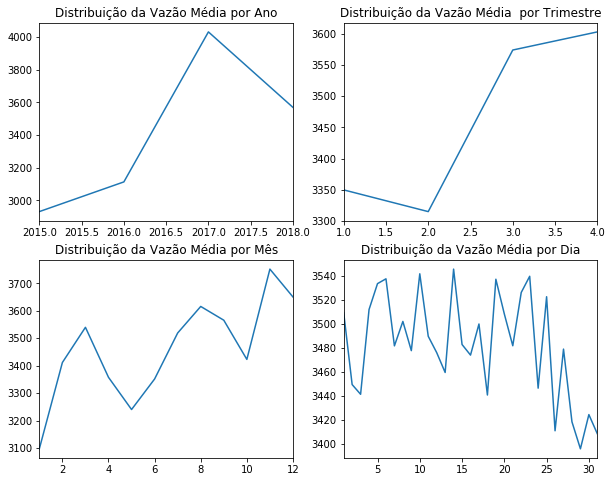

In [80]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
base_vazao.groupby('year').downthpt.agg('mean').plot()
plt.xlabel('')
plt.title('Distribuição da Vazão Média por Ano')

plt.subplot(2,2,2)
base_vazao.groupby('quarter').downthpt.agg('mean').plot()
plt.xlabel('')
plt.title('Distribuição da Vazão Média  por Trimestre')

plt.subplot(2,2,3)
base_vazao.groupby('month').downthpt.agg('mean').plot()
plt.xlabel('')
plt.title('Distribuição da Vazão Média por Mês')

plt.subplot(2,2,4)
base_vazao.groupby('day').downthpt.agg('mean').plot()
plt.xlabel('')
plt.title('Distribuição da Vazão Média por Dia')
plt.show()

Vazão por Ano

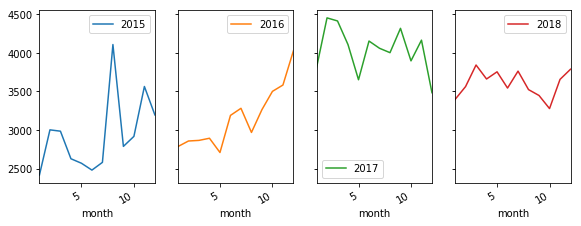

In [81]:
pd.pivot_table(base_vazao, 
               values='downthpt', 
               index='month',
               columns='year').plot(subplots = True, figsize=(12,12), layout=(3,5), sharey=True);

Vazão Ativa em Dias da semana vs. Finais de semana

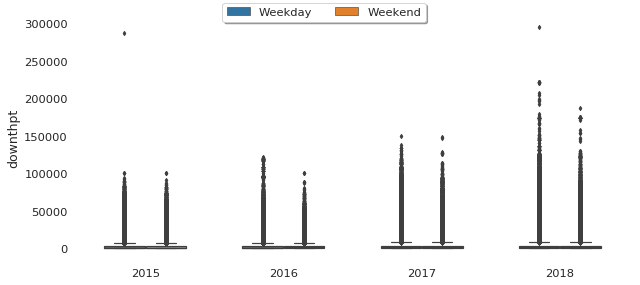

In [92]:
dic={0:'Weekend',1:'Weekday'}
base_vazao['Day'] = base_vazao.weekday.map(dic)
a=plt.figure(figsize=(9,4)) 
plt1=sns.boxplot('year','downthpt',hue='Day',width=0.6,fliersize=3,
                    data=base_vazao)                                                                                                                                                                                                                                                                                                                                                 
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

Plot do Fator da Vazão pelo Final de semena/Dia da Semana

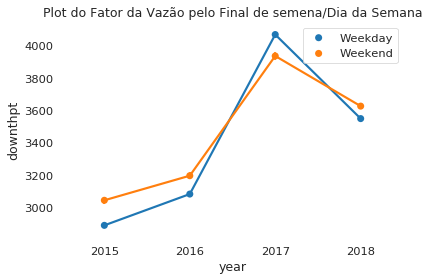

In [94]:
plt1=sns.factorplot('year','downthpt',hue='Day',
                    data=base_vazao, size=4, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
plt.title('Plot do Fator da Vazão pelo Final de semena/Dia da Semana')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper right');

Dickey-Fuller test

In [95]:
base_vazao=base_vazao.loc[:,['timestamp','downthpt', 'year','quarter','month','day']]

In [100]:
base_vazao['timestamp']=pd.to_datetime(base_vazao['timestamp'])

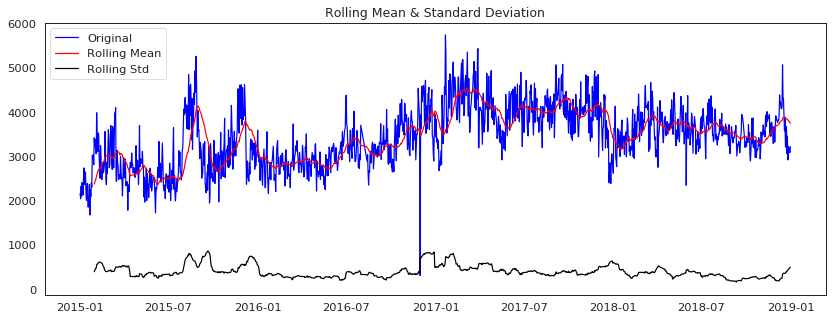

<Resultados of Dickey-Fuller Test>
Teste Estatístico               -4.5311
p-value                          0.0002
#Lags Used                       7.0000
Numero de observações usada   1442.0000
Valor Crítico (5%)              -2.8635
Valor Crítico (1%)              -3.4349
Valor Crítico (10%)             -2.5678
dtype: float64


In [103]:
df2=base_vazao.resample('D', on='timestamp', how=np.mean)

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Resultados of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Teste Estatístico','p-value','#Lags Used','Numero de observações usada'])
    for key,value in dftest[4].items():
        dfoutput['Valor Crítico (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.downthpt.dropna())

In [ ]:
plt.figure(figsize=(20,10))

plt.plot(X_train_values.index, test, '.-', color='red', label='Train set', alpha=0.5)
plt.plot(train.index, y_test, '.-', color='blue', label='Test set', alpha=0.5)

plt.ylabel(r'Throughput [Kbits/s]' % magnitude, fontsize=14)
plt.xlabel('datetime', fontsize=14) #TODO: set x values as actual dates

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

### LSTM 

In [2]:
base_vazao = pd.read_csv('../base_vazao_neubot.csv', delimiter=',')

In [3]:
columnsTitles = ['connect_time','delta_sys_time','delta_user_time','rate','received','request_ticks','downthpt','iteration','year','month','day','weekday','hour','minute','second']
base_vazao = base_vazao.reindex(columns=columnsTitles)

In [35]:
base_vazao.head(10)

,connect_time,delta_sys_time,delta_user_time,rate,received,request_ticks,downthpt,iteration,year,month,day,weekday,hour,minute,second
0,0.1486,0.0000,0.0000,100,25129,265367.7104,329.9902,0,2015,1,1,3,0,4,42
1,0.1486,0.0000,0.0000,300,75129,265368.3201,785.4466,1,2015,1,1,3,0,4,43
2,0.1486,0.0000,0.0000,700,175130,265369.0858,1813.4163,2,2015,1,1,3,0,4,44
3,0.1486,0.0000,0.0000,1500,375130,265369.8589,1096.1336,3,2015,1,1,3,0,4,47
4,0.1486,0.0000,0.0000,500,125130,265372.5974,617.4167,4,2015,1,1,3,0,4,48
5,0.1486,0.0000,0.0000,500,125130,265374.2193,2117.9832,5,2015,1,1,3,0,4,49
6,0.1486,0.0000,0.0000,2000,500130,265374.6924,2169.5523,6,2015,1,1,3,0,4,51
7,0.1486,0.0000,0.0156,2000,500130,265376.5371,659.0281,7,2015,1,1,3,0,4,57
8,0.1486,0.0000,0.0000,100,25129,265382.6087,654.6274,8,2015,1,1,3,0,4,57
9,0.1486,0.0000,0.0000,500,125130,265382.9163,1083.0186,9,2015,1,1,3,0,4,58


### Data selection based on the Pearson correlation coefficient matrix

As a baseline we will pick the feauture from the features $X$ that has the highest Pearson correlation coefficient $P$ with the target $y$. Then the other features that have a Pearson correlation coefficient which suffixes $|P|$ < 0.1 with this feature are filtered out.

Saving heatmap


<Figure size 432x288 with 0 Axes>

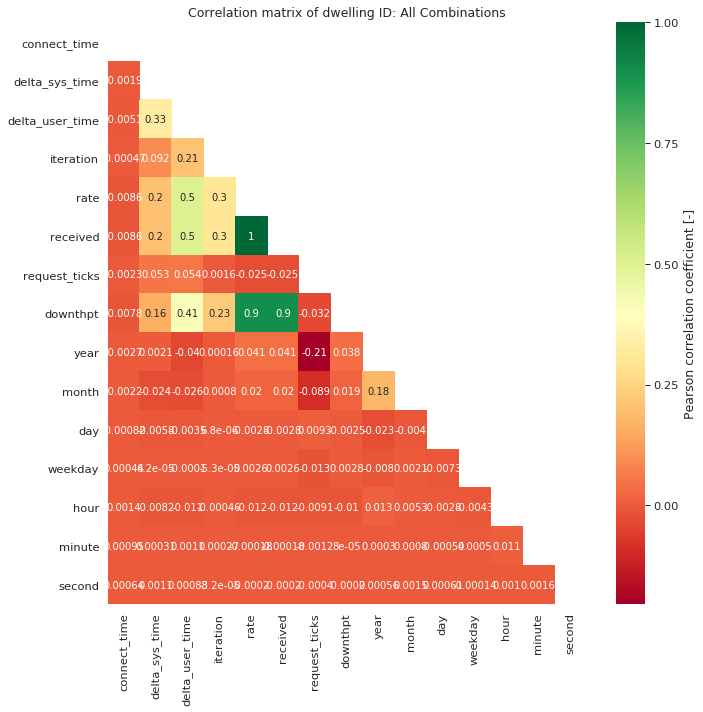

In [19]:
fig = create_corr_matrix(base_vazao, 'All Combinations', True, size=(10,10))

Reindex or change the order of columns

###  Normalização

Quais atributos são categóricos, númericos, contínuos, nominais?

<b>Categóricos</b>: year, month, day_of_week, hour, minute, second.

<b>Contínuo</b>: connect_time, delta_sys_time, delta_user_time, iteration, rate, received, request_ticks, downthpt

### MinMaxScaler/One Hot Coding/Get Dummies/OrdinalEncoder

In [4]:
def min_max_scaler(input_feature):
    scaler = MinMaxScaler(feature_range=(0, 1))
    input_feature[:,:6] = scaler.fit_transform(input_feature[:,:6])
    return input_feature

def ordinal_encoder(input_feature):
    from sklearn.preprocessing import OrdinalEncoder
    encoder = OrdinalEncoder()
    input_feature[:,7] = input_feature[:,7].reshape(len(input_feature[:,7]),1)
    input_feature[:,7] = encoder.fit_transform(input_feature[:,7])
    return input_feature

def one_hot_coding(input_feature):
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    input_feature[:,7:] = np.reshape(len(input_feature[:,7:]), (-1,1))
    input_feature[:,7:] = onehot_encoder.fit_transform(input_feature[:,7:])
    return input_feature

def get_dumies(base_vazao):
    for i in ['year','month','day','weekday','hour','minute','second']:
        cat_dummies = pd.get_dummies(base_vazao[i], prefix = i,prefix_sep='_', drop_first=True)
        base_vazao = base_vazao.drop(i, axis = 1).join(cat_dummies)
    return base_vazao

def prepare_inputs(base_vazao):
    for col in range(base_vazao.shape[1]):
        base_vazao.iloc[:, col] = base_vazao.iloc[:, col].apply(lambda row: np.reshape(row,(-1, 1)))
        base_vazao.iloc[:, col] = onehot_encoder.fit_transform(base_vazao.iloc[:, col])                                                   
    return base_vazao

input_feature = base_vazao.values.astype('float32')
# input_feature = get_dumies(base_vazao)
input_feature = min_max_scaler(input_feature)
# input_feature = ordinal_encoder(input_feature)
input_feature = one_hot_coding(input_feature)

### Modeling my LSTM with API Keras

Multi-Step model

In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

In [7]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
    return np.array(data), np.array(labels)

In [8]:
input_feature = np.array(input_feature)
TRAIN_SIZE = int(len(input_feature) * 0.80)
dataset = input_feature[0:TRAIN_SIZE,:]
TRAIN_SPLIT = int(len(dataset) * 0.80)
TEST_SPLIT = input_feature[len(dataset):len(input_feature),:]

# train_size = int(len(input_feature) * 0.60)
# test_size = len(input_feature) - train_size
# train, test = dataset[0:TRAIN_SPLIT,:], input_feature[TRAIN_SPLIT:len(dataset),:]

In [14]:
past_history = 30
future_target = 11
STEP = 2

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 6], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 6],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [15]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target throughput to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (15, 15)

 Target throughput to predict : (11,)


In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [16]:
# reshape input to be [samples, time steps, features]
# X_train = np.reshape(train, (train.shape[0], 1, train.shape[1]))
# X_test = np.reshape(test, (test.shape[0], 1, test.shape[1]))

Arquitetura do Modelo

In [61]:
import tensorflow as tf
from keras import optimizers

def createModel():
    
    batch_size = 50
    epochs = 10

    a = Input(shape=(x_train_multi[:,-1,].shape[0], x_train_multi[:,-1,].shape[1]))
    x = LSTM(100, return_sequences=True)(a)
    # x = LSTM(100, return_sequences=True)(x)
    # x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.2)(x)
    x = Dense(30,)(x)
    x = Dense(10,)(x)
    
    # x = GRU(100, activation ='tanh', recurrent_dropout=0.2, return_sequences = True)(a)
    # x = Activation('relu')(x)
    # x = GRU(100, activation ='tanh', recurrent_dropout=0.2, return_sequences = False)(x)
    # x = Dense(50)(x)
    # x = Activation('relu')(x)
    # x = Dropout(0.2)(x)
    x = Dense(1, activation='linear')(x)
    model = Model(inputs=a, outputs=x)
    model.summary()
    
    return model

In [74]:
def compile_model(model):
    reduce_lr  = ReduceLROnPlateau(monitor='val_loss',       # monitora a perda na validacao
                               factor=0.2, 
                               patience=40, verbose=0, 
                               mode='auto')
    early = EarlyStopping(monitor='val_loss', patience=45, verbose=0)
    
    # optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
    sgd = optimizers.SGD(lr=0.01, decay=1e-5, momentum=0.9)
    
    # model.compile(loss=tf.keras.losses.Huber(), optimizer=sgd, metrics=['mae'])
    model.compile(loss='mse', optimizer=sgd, metrics=['mae', 'mse', 'mape'])
    history = model.fit(X_train, X_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[reduce_lr, early],
                    verbose=1)

In [ ]:
model = createModel()
history = compile_model(model)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 7723989, 15)       0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 7723989, 100)      46400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7723989, 100)      0         
_________________________________________________________________
dense_4 (Dense)              (None, 7723989, 30)       3030      
_________________________________________________________________
dense_5 (Dense)              (None, 7723989, 10)       310       
_________________________________________________________________
dense_6 (Dense)              (None, 7723989, 1)        11        
Total params: 49,751
Trainable params: 49,751
Non-trainable params: 0
_______________________________________________________

### Plot Visualizations 

Plot da perda do Modelo

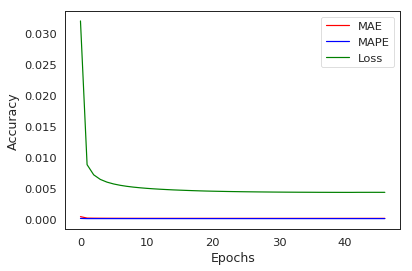

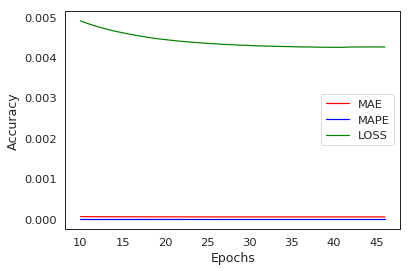

<Figure size 432x288 with 0 Axes>

In [32]:

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
result_dir = './plots'
mae=history.history['mae']
mape=history.history['mape']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.plot(epochs, mape, 'g')
# plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "MAPE", "Loss"])
plt.savefig(os.path.join(result_dir, 'plot_metrics.png'))

plt.figure()

epochs_zoom = epochs[10:]
mae_zoom = mae[10:]
mape_zoom = mape[10:]
loss_zoom = loss[10:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'red')
plt.plot(epochs_zoom, loss_zoom, 'blue')
plt.plot(epochs_zoom, mape_zoom, 'green')
# plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "MAPE", "LOSS"])
plt.savefig(os.path.join(result_dir, 'plot_metrics_zoom.png'))

plt.figure()
plt.show()

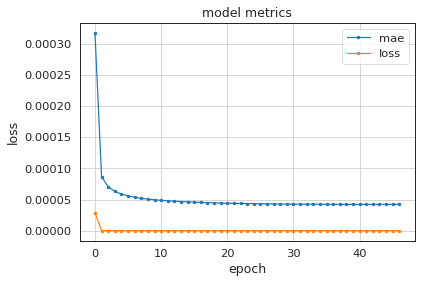

In [33]:
def plot_history_metrics(history, result_dir):
    # plot metrics
    plt.plot(history.history['mae'], marker='.')
    plt.plot(history.history['loss'], marker='.')
    # plt.title('model metrics')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.grid()
    plt.legend(['mae','loss'], loc='best')
    plt.savefig(os.path.join(result_dir, 'plot_mae_loss.png'))
    plt.show()
    
plot_history_metrics(history, result_dir)

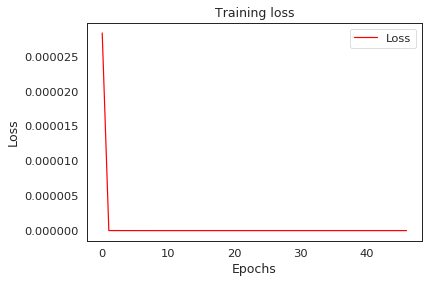

In [56]:
def plot_history_loss(history, result_dir):
    #-----------------------------------------------------------
    # Retrieve a list of list results on training and test data
    # sets for each training epoch
    #-----------------------------------------------------------
    loss=history.history['loss']

    epochs=range(len(loss)) # Get number of epochs

    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'r')
    plt.title('Training loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Loss"])
    
plot_history_loss(history, result_dir)

Visualize the model's training progress using the stats stored in the history object.

In [34]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,lr,mae,mape,val_loss,val_mae,val_mape,epoch
42,0.0000,0.0020,0.0000,0.0042,0.0000,0.0000,0.0027,42
43,0.0000,0.0020,0.0000,0.0042,0.0000,0.0000,0.0027,43
44,0.0000,0.0020,0.0000,0.0043,0.0000,0.0000,0.0027,44
45,0.0000,0.0020,0.0000,0.0042,0.0000,0.0000,0.0027,45
46,0.0000,0.0020,0.0000,0.0042,0.0000,0.0000,0.0027,46


In [43]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
# plotter.plot({'Basic': history}, metric = "mae")
# plt.ylim([0, 10])
# plt.ylabel('MAE')

In [45]:
# plotter.plot({'Basic': history}, metric = "mape")
# plt.ylim([0, 20])
# plt.ylabel('MAPE [MPG^2]')